In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [55]:
df = pd.read_csv('DHK_AQI.csv')
df = df.set_index('Date')    
df.index = pd.to_datetime(df.index)   

C:\Users\HP\AppData\Local\Temp\ipykernel_4496\2260202093.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)   # This converts the index (which now contains datetime values) into a proper datetime format


In [10]:
df

,AQI
Date,
2016-01-03 04:00:00,296
2016-01-03 05:00:00,314
2016-01-03 06:00:00,307
2016-01-03 07:00:00,288
2016-01-03 08:00:00,278
...,...
2022-05-31 21:00:00,154
2022-05-31 22:00:00,154
2022-05-31 23:00:00,154


In [9]:
null_values = df[df.index.isnull()]

print(null_values)

Empty DataFrame
Columns: [AQI]
Index: []


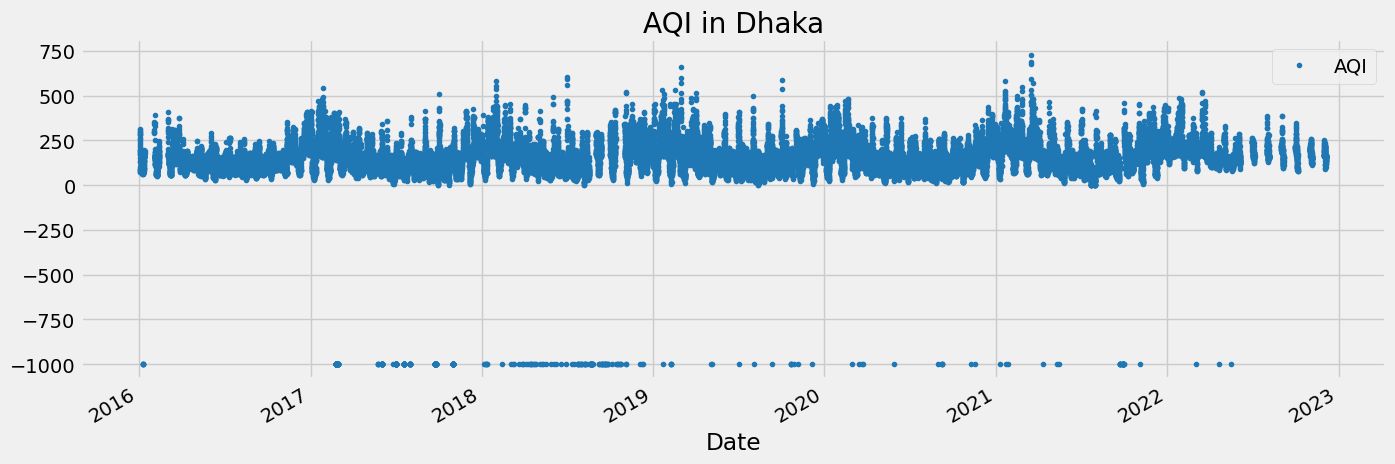

In [56]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AQI in Dhaka')
plt.show()

<Axes: ylabel='Frequency'>

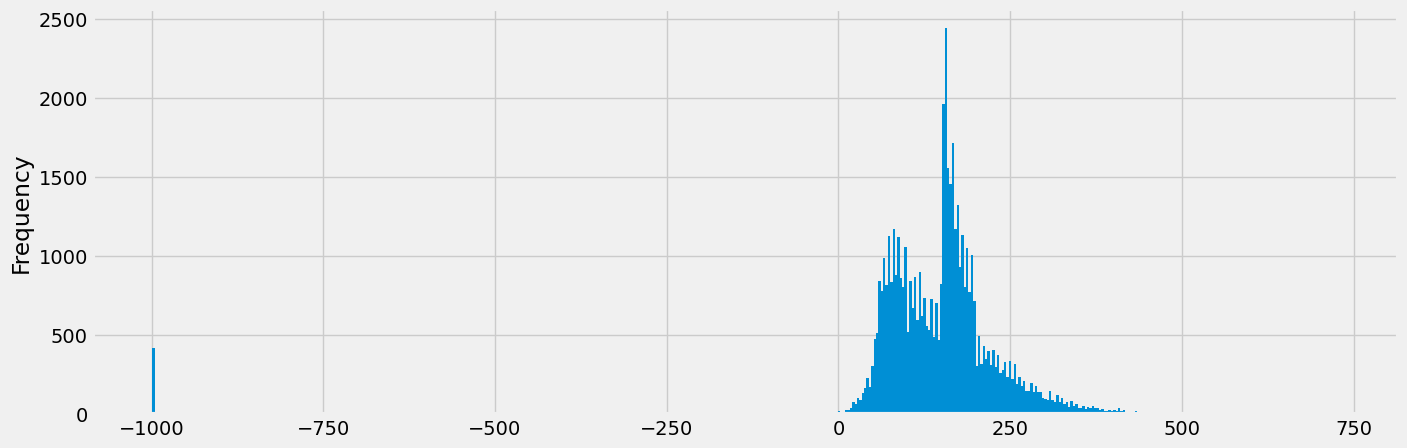

In [156]:
df['AQI'].plot(kind='hist', bins=500,figsize=(15, 5))

<Axes: title={'center': 'Outliers'}, xlabel='Date'>

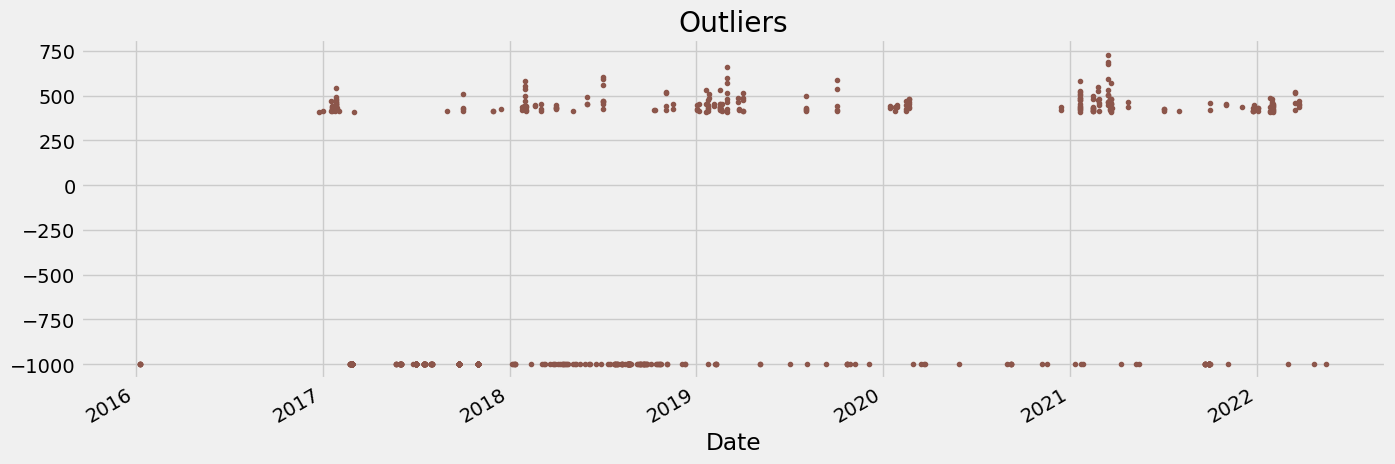

In [13]:
df.query('AQI < 0 | AQI> 410')['AQI'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],                           
          title='Outliers')

In [59]:
df = df.query('AQI > 0 & AQI < 410').copy()
df

,AQI
Date,
2016-01-03 04:00:00,296
2016-01-03 05:00:00,314
2016-01-03 06:00:00,307
2016-01-03 07:00:00,288
2016-01-03 08:00:00,278
...,...
2022-05-31 21:00:00,154
2022-05-31 22:00:00,154
2022-05-31 23:00:00,154


In [17]:
print(df['AQI'].max())                        

409


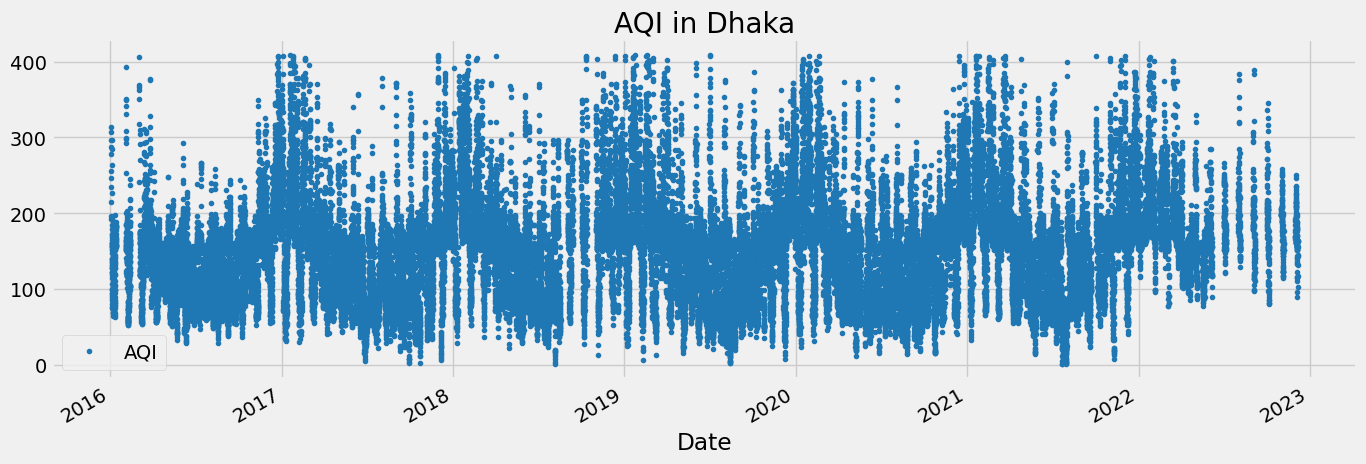

In [61]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AQI in Dhaka')
plt.show()

In [63]:
train = df.loc[df.index < '01-01-2021']    
test = df.loc[df.index >= '01-01-2021']

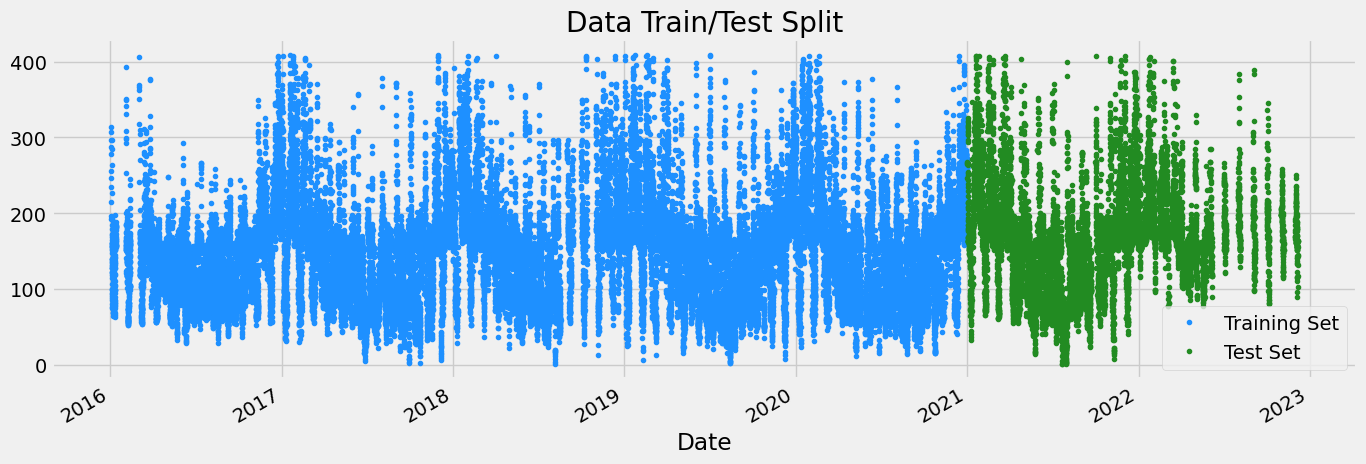

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split',style='.', color='dodgerblue')    
test.plot(ax=ax, label='Test Set',style='.', color='forestgreen')                                        

ax.legend(['Training Set', 'Test Set'])
plt.show()

In [71]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24*30) 
                                                            
df = df.sort_index()

In [73]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year                                          
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Rolling statistics (short-term trends)
    df['rolling_mean_7d'] = df['AQI'].rolling(window=30*24, min_periods=1).mean()  
    df['rolling_std_7d'] = df['AQI'].rolling(window=30*24, min_periods=1).std()  

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24) 
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24) 

    df['ema_7d'] = df['AQI'].ewm(span=30*24, adjust=False).mean()          
    df['hour_dayofweek'] = df['hour'] * df['dayofweek']
    df['month_year'] = df['month'] * df['year']
    
    return df

df = create_features(df)

In [27]:
df

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,rolling_mean_7d,rolling_std_7d,hour_sin,hour_cos,ema_7d,hour_dayofweek,month_year
Date,,,,,,,,,,,,,,,,,
2016-01-03 04:00:00,296,4,6,1,1,2016,3,3,53,1,296.000000,NaN,0.866025,5.000000e-01,296.000000,24,2016
2016-01-03 05:00:00,314,5,6,1,1,2016,3,3,53,1,305.000000,12.727922,0.965926,2.588190e-01,296.049931,30,2016
2016-01-03 06:00:00,307,6,6,1,1,2016,3,3,53,1,305.666667,9.073772,1.000000,6.123234e-17,296.080305,36,2016
2016-01-03 07:00:00,288,7,6,1,1,2016,3,3,53,1,301.250000,11.528949,0.965926,-2.588190e-01,296.057891,42,2016
2016-01-03 08:00:00,278,8,6,1,1,2016,3,3,53,1,296.600000,14.415270,0.866025,-5.000000e-01,296.007800,48,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,163,19,0,4,12,2022,339,5,49,0,184.744444,45.467392,-0.965926,2.588190e-01,177.250181,0,24264
2022-12-05 20:00:00,163,20,0,4,12,2022,339,5,49,0,184.788889,45.430408,-0.866025,5.000000e-01,177.210652,0,24264
2022-12-05 21:00:00,163,21,0,4,12,2022,339,5,49,0,184.826389,45.401214,-0.707107,7.071068e-01,177.171233,0,24264


In [75]:
def add_lags(df):
    # Daily lags
    df['lag1'] = df['AQI'].shift(1)  
    df['lag7'] = df['AQI'].shift(7) 

    df['lag30'] = df['AQI'].shift(30)  
    df['lag14'] = df['AQI'].shift(14) 
    df['lag90'] = df['AQI'].shift(90)  
    df['lag120'] = df['AQI'].shift(120)  

    df['lag365'] = df['AQI'].shift(365) 
    df['lag730'] = df['AQI'].shift(730) 
    df['lag1095'] = df['AQI'].shift(1095)  

    return df


In [77]:
df = add_lags(df)

In [33]:
df

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,...,month_year,lag1,lag7,lag30,lag14,lag90,lag120,lag365,lag730,lag1095
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-03 04:00:00,296,4,6,1,1,2016,3,3,53,1,...,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 05:00:00,314,5,6,1,1,2016,3,3,53,1,...,2016,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 06:00:00,307,6,6,1,1,2016,3,3,53,1,...,2016,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 07:00:00,288,7,6,1,1,2016,3,3,53,1,...,2016,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 08:00:00,278,8,6,1,1,2016,3,3,53,1,...,2016,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,163,19,0,4,12,2022,339,5,49,0,...,24264,132.0,141.0,164.0,122.0,227.0,160.0,142.0,162.0,136.0
2022-12-05 20:00:00,163,20,0,4,12,2022,339,5,49,0,...,24264,163.0,141.0,157.0,133.0,207.0,159.0,152.0,156.0,129.0
2022-12-05 21:00:00,163,21,0,4,12,2022,339,5,49,0,...,24264,163.0,143.0,156.0,170.0,199.0,152.0,153.0,143.0,111.0


In [79]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24*30)
df = df.sort_index()

fold = 0          
preds = []        
scores = []       

for train_idx, val_idx in tss.split(df):      
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','is_weekend','rolling_mean_7d','rolling_std_7d','ema_7d','hour_dayofweek','month_year','hour_sin','hour_cos',
                'lag1','lag7','lag30','lag365','lag730','lag1095','lag14','lag90','lag120']
    TARGET = 'AQI'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.03)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)             
    preds.append(y_pred)  
    test['prediction'] = reg.predict(X_test) 
    score = np.sqrt(mean_squared_error(y_test, y_pred))            
    scores.append(score)

    r2_score = reg.score(X_test, y_test)
    print(f"Fold {fold}: RMSE={score}, R^2={r2_score}")

    fold += 1

print(f'Average RMSE: {np.mean(scores)}')

[0]	validation_0-rmse:132.89914	validation_1-rmse:155.81270
[100]	validation_0-rmse:14.54373	validation_1-rmse:23.81458
[200]	validation_0-rmse:12.11349	validation_1-rmse:21.52881
[277]	validation_0-rmse:11.78144	validation_1-rmse:21.69510
Fold 0: RMSE=21.478127356951795, R^2=0.9030867153460231
[0]	validation_0-rmse:146.78937	validation_1-rmse:174.52456
[100]	validation_0-rmse:17.27583	validation_1-rmse:24.92613
[200]	validation_0-rmse:14.92487	validation_1-rmse:23.07169
[222]	validation_0-rmse:14.82789	validation_1-rmse:23.07240
Fold 1: RMSE=23.06201158744199, R^2=0.895219778986241
[0]	validation_0-rmse:158.50422	validation_1-rmse:157.30393
[100]	validation_0-rmse:19.35070	validation_1-rmse:20.58252
[200]	validation_0-rmse:17.03463	validation_1-rmse:18.94283
[300]	validation_0-rmse:16.67208	validation_1-rmse:18.93170
[331]	validation_0-rmse:16.58552	validation_1-rmse:18.93768
Fold 2: RMSE=18.910693119236097, R^2=0.9238351558841766
[0]	validation_0-rmse:159.01709	validation_1-rmse:163.

In [81]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True) 
df

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,...,lag1,lag7,lag30,lag14,lag90,lag120,lag365,lag730,lag1095,prediction
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-03 04:00:00,296,4,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 05:00:00,314,5,6,1,1,2016,3,3,53,1,...,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 06:00:00,307,6,6,1,1,2016,3,3,53,1,...,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 07:00:00,288,7,6,1,1,2016,3,3,53,1,...,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03 08:00:00,278,8,6,1,1,2016,3,3,53,1,...,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,163,19,0,4,12,2022,339,5,49,0,...,132.0,141.0,164.0,122.0,227.0,160.0,142.0,162.0,136.0,138.114166
2022-12-05 20:00:00,163,20,0,4,12,2022,339,5,49,0,...,163.0,141.0,157.0,133.0,207.0,159.0,152.0,156.0,129.0,167.825394
2022-12-05 21:00:00,163,21,0,4,12,2022,339,5,49,0,...,163.0,143.0,156.0,170.0,199.0,152.0,153.0,143.0,111.0,167.505722


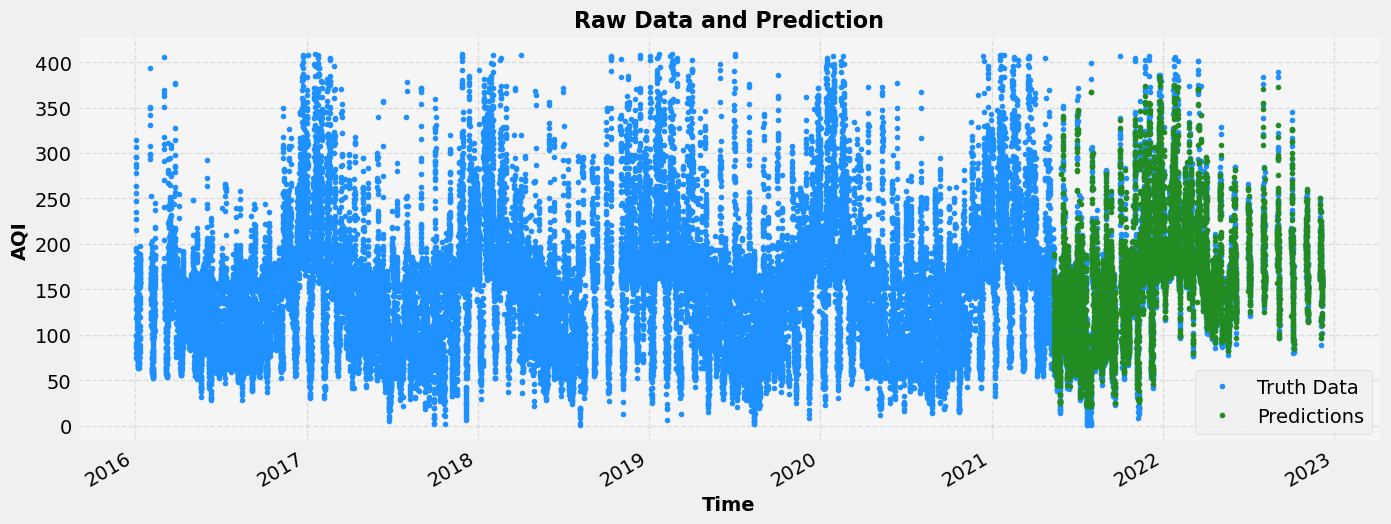

In [125]:
import matplotlib.pyplot as plt

# Plot the data
ax = df[['AQI']].plot(figsize=(15, 6), color='dodgerblue', style='.', markersize=6) 
df['prediction'].plot(ax=ax, color='forestgreen', style='.', markersize=6)  

ax.set_title('Raw Data and Prediction', fontsize=16, fontweight='bold')  
ax.set_ylabel('AQI', fontsize=14, fontweight='bold') 
ax.set_xlabel('Time', fontsize=14, fontweight='bold') 

ax.grid(True, linestyle='--', alpha=0.6)  
ax.set_facecolor('#f5f5f5')  

plt.legend(['Truth Data', 'Predictions'])

plt.savefig('raw_data_and_prediction.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [85]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, test['prediction'])             
print(f"R² Score: {r2:.4f}")

R² Score: 0.9300


In [87]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 19.7924
Fold scores:[21.478127356951795, 23.06201158744199, 18.910693119236097, 18.352406883663605, 17.158630535984486]


In [146]:
# Predicting Future

In [89]:
# Retrain on all data
df = create_features(df)  # No indentation error

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'is_weekend', 
            'rolling_mean_7d', 'rolling_std_7d', 'ema_7d', 'hour_dayofweek', 'month_year', 
            'hour_sin', 'hour_cos', 'lag1', 'lag7', 'lag30', 'lag365', 'lag730', 'lag1095', 
            'lag14', 'lag90', 'lag120']

TARGET = 'AQI'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.03)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:160.81726
[100]	validation_0-rmse:19.79395
[200]	validation_0-rmse:17.66986
[300]	validation_0-rmse:17.42932
[400]	validation_0-rmse:17.24668
[500]	validation_0-rmse:17.06498
[600]	validation_0-rmse:16.90666
[700]	validation_0-rmse:16.75265
[800]	validation_0-rmse:16.60243
[900]	validation_0-rmse:16.44725
[999]	validation_0-rmse:16.32565


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [91]:
future = pd.date_range('2025-01-01 00:00:00', '2025-06-30 23:00:00', freq='24h')  # Adjust date range as needed
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df['isFuture'] = False
df = add_lags(df)

df_and_future = pd.concat([df, future_df])  
df_and_future = create_features(df_and_future)  

for i in range(len(future_df)):
    idx = future_df.index[i]  

    X_future = pd.DataFrame(df_and_future.loc[idx, FEATURES]).T  

    if not X_future.isnull().values.any():
        predicted_aqi = reg.predict(X_future)[0] 
        df_and_future.at[idx, 'AQI'] = predicted_aqi 

    df_and_future = add_lags(df_and_future)  


In [93]:
df_and_future

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,...,lag7,lag30,lag14,lag90,lag120,lag365,lag730,lag1095,prediction,isFuture
2016-01-03 04:00:00,296.0,4,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-03 05:00:00,314.0,5,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-03 06:00:00,307.0,6,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-03 07:00:00,288.0,7,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-03 08:00:00,278.0,8,6,1,1,2016,3,3,53,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26 00:00:00,NaN,0,3,2,6,2025,177,26,26,0,...,NaN,NaN,NaN,NaN,NaN,231.0,274.0,168.0,NaN,True
2025-06-27 00:00:00,NaN,0,4,2,6,2025,178,27,26,0,...,NaN,NaN,NaN,NaN,NaN,237.0,268.0,166.0,NaN,True
2025-06-28 00:00:00,NaN,0,5,2,6,2025,179,28,26,1,...,NaN,NaN,NaN,NaN,NaN,249.0,246.0,162.0,NaN,True
2025-06-29 00:00:00,NaN,0,6,2,6,2025,180,29,26,1,...,NaN,NaN,NaN,NaN,NaN,239.0,247.0,163.0,NaN,True


In [95]:
future_w_features = df_and_future.query('isFuture').copy()

In [97]:
future_w_features

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,...,lag7,lag30,lag14,lag90,lag120,lag365,lag730,lag1095,prediction,isFuture
2025-01-01,NaN,0,2,1,1,2025,1,1,1,0,...,102.0,155.0,156.0,189.0,190.0,158.0,118.0,90.0,NaN,True
2025-01-02,NaN,0,3,1,1,2025,2,2,1,0,...,132.0,151.0,153.0,196.0,192.0,157.0,120.0,119.0,NaN,True
2025-01-03,NaN,0,4,1,1,2025,3,3,1,0,...,163.0,158.0,141.0,224.0,184.0,141.0,127.0,144.0,NaN,True
2025-01-04,NaN,0,5,1,1,2025,4,4,1,1,...,163.0,157.0,141.0,214.0,178.0,127.0,102.0,129.0,NaN,True
2025-01-05,NaN,0,6,1,1,2025,5,5,1,1,...,163.0,158.0,143.0,195.0,175.0,111.0,90.0,135.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26,NaN,0,3,2,6,2025,177,26,26,0,...,NaN,NaN,NaN,NaN,NaN,231.0,274.0,168.0,NaN,True
2025-06-27,NaN,0,4,2,6,2025,178,27,26,0,...,NaN,NaN,NaN,NaN,NaN,237.0,268.0,166.0,NaN,True
2025-06-28,NaN,0,5,2,6,2025,179,28,26,1,...,NaN,NaN,NaN,NaN,NaN,249.0,246.0,162.0,NaN,True
2025-06-29,NaN,0,6,2,6,2025,180,29,26,1,...,NaN,NaN,NaN,NaN,NaN,239.0,247.0,163.0,NaN,True


In [99]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

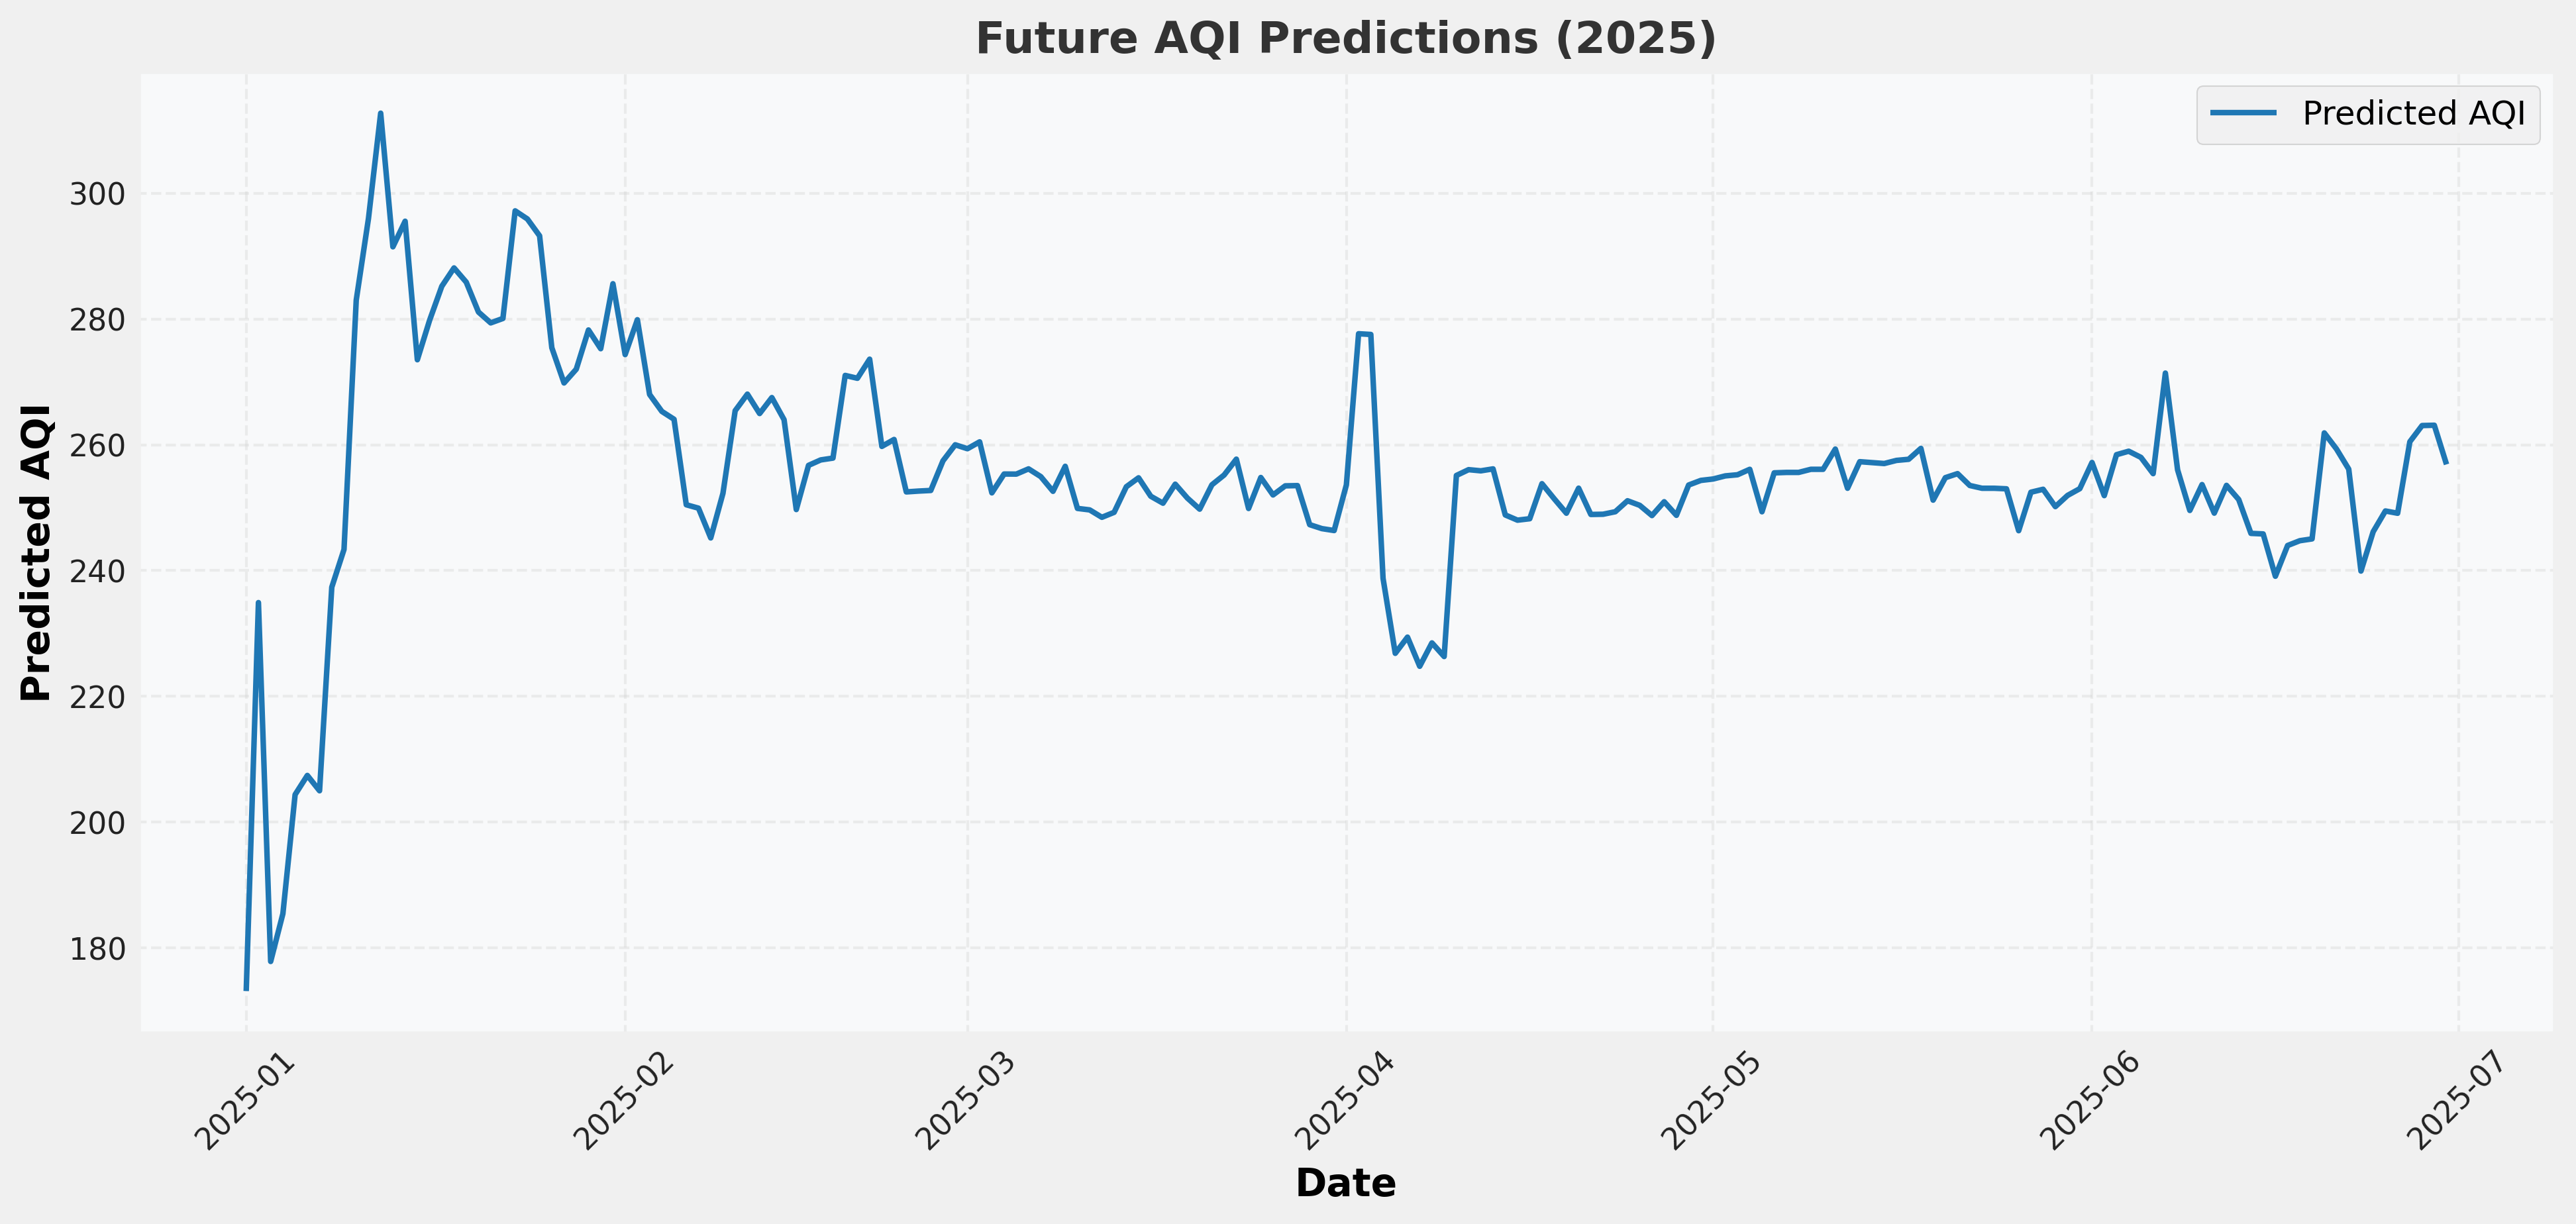

In [131]:
plt.figure(figsize=(14, 6), dpi=300)  

plt.plot(future_w_features.index, 
         future_w_features['pred'], 
         color='#1f77b4',
         lw=2, 
         label='Predicted AQI')

if 'lower_bound' in future_w_features.columns and 'upper_bound' in future_w_features.columns:
    plt.fill_between(future_w_features.index, 
                     future_w_features['lower_bound'], 
                     future_w_features['upper_bound'], 
                     color='#aec7e8',  # Light Blue
                     alpha=0.3, 
                     label='Confidence Interval')

plt.title('Future AQI Predictions (2025)', fontsize=16, fontweight='bold', color='#333333')
plt.ylabel('Predicted AQI', fontsize=14, fontweight='bold')  
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

plt.xticks(rotation=45, fontsize=11, color='#222222')
plt.yticks(fontsize=11, color='#222222')

plt.gca().set_facecolor('#f8f9fa')  

plt.savefig("future_aqi_predictions.png", dpi=300, bbox_inches='tight')

plt.show()


In [496]:
# Specific Prediction

In [103]:
AQI_feb7 = future_w_features.loc['2025-02-07']
print(AQI_feb7)

AQI                       NaN
hour                        0
dayofweek                   4
quarter                     1
month                       2
year                     2025
dayofyear                  38
dayofmonth                  7
weekofyear                  6
is_weekend                  0
rolling_mean_7d    183.277126
rolling_std_7d      45.639438
hour_sin                  0.0
hour_cos                  1.0
ema_7d             177.020662
hour_dayofweek              0
month_year               4050
lag1                      NaN
lag7                      NaN
lag30                     NaN
lag14                     NaN
lag90                   176.0
lag120                  167.0
lag365                  207.0
lag730                  185.0
lag1095                 156.0
prediction                NaN
isFuture                 True
pred               249.922852
Name: 2025-02-07 00:00:00, dtype: object


In [105]:
future_w_features

,AQI,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,...,lag30,lag14,lag90,lag120,lag365,lag730,lag1095,prediction,isFuture,pred
2025-01-01,NaN,0,2,1,1,2025,1,1,1,0,...,155.0,156.0,189.0,190.0,158.0,118.0,90.0,NaN,True,173.135376
2025-01-02,NaN,0,3,1,1,2025,2,2,1,0,...,151.0,153.0,196.0,192.0,157.0,120.0,119.0,NaN,True,234.910706
2025-01-03,NaN,0,4,1,1,2025,3,3,1,0,...,158.0,141.0,224.0,184.0,141.0,127.0,144.0,NaN,True,177.843536
2025-01-04,NaN,0,5,1,1,2025,4,4,1,1,...,157.0,141.0,214.0,178.0,127.0,102.0,129.0,NaN,True,185.430679
2025-01-05,NaN,0,6,1,1,2025,5,5,1,1,...,158.0,143.0,195.0,175.0,111.0,90.0,135.0,NaN,True,204.376144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26,NaN,0,3,2,6,2025,177,26,26,0,...,NaN,NaN,NaN,NaN,231.0,274.0,168.0,NaN,True,249.113876
2025-06-27,NaN,0,4,2,6,2025,178,27,26,0,...,NaN,NaN,NaN,NaN,237.0,268.0,166.0,NaN,True,260.491455
2025-06-28,NaN,0,5,2,6,2025,179,28,26,1,...,NaN,NaN,NaN,NaN,249.0,246.0,162.0,NaN,True,263.060608
2025-06-29,NaN,0,6,2,6,2025,180,29,26,1,...,NaN,NaN,NaN,NaN,239.0,247.0,163.0,NaN,True,263.112274


In [107]:
Data_2025 = future_w_features.loc['2025-01-01':'2025-06-30'].reset_index()

In [109]:
pd.set_option('display.max_rows', None)
print(Data_2025[['index', 'pred']])

         index        pred
0   2025-01-01  173.135376
1   2025-01-02  234.910706
2   2025-01-03  177.843536
3   2025-01-04  185.430679
4   2025-01-05  204.376144
5   2025-01-06  207.428955
6   2025-01-07  204.986572
7   2025-01-08  237.359207
8   2025-01-09  243.358688
9   2025-01-10  282.995941
10  2025-01-11  295.963623
11  2025-01-12  312.732758
12  2025-01-13  291.482574
13  2025-01-14  295.550842
14  2025-01-15  273.524628
15  2025-01-16  279.789459
16  2025-01-17  285.206421
17  2025-01-18  288.127594
18  2025-01-19  285.862122
19  2025-01-20  281.111084
20  2025-01-21  279.386597
21  2025-01-22  280.090607
22  2025-01-23  297.203156
23  2025-01-24  295.912109
24  2025-01-25  293.230011
25  2025-01-26  275.435669
26  2025-01-27  269.834045
27  2025-01-28  272.022339
28  2025-01-29  278.261780
29  2025-01-30  275.279846
30  2025-01-31  285.614624
31  2025-02-01  274.346344
32  2025-02-02  279.890778
33  2025-02-03  268.002838
34  2025-02-04  265.312012
35  2025-02-05  264.061432
3